In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'
import variational
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from itertools import cycle
import os
import time
import math
import pandas as pd
from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
    
import copy
import torch.nn as nn
from torch.autograd import Variable
from typing import List
import itertools
from tqdm.autonotebook import tqdm
from models import *
import models
from logger import *
import wandb

from thirdparty.repdistiller.helper.util import adjust_learning_rate as sgda_adjust_learning_rate
from thirdparty.repdistiller.distiller_zoo import DistillKL, HintLoss, Attention, Similarity, Correlation, VIDLoss, RKDLoss
from thirdparty.repdistiller.distiller_zoo import PKT, ABLoss, FactorTransfer, KDSVD, FSP, NSTLoss

from thirdparty.repdistiller.helper.loops import train_distill, train_distill_hide, train_distill_linear, train_vanilla, train_negrad, train_bcu, train_bcu_distill, validate
from thirdparty.repdistiller.helper.pretrain import init

from scipy import optimize

/tmp/ipykernel_343642/2175754929.py:24: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
def pdb():
    import pdb
    pdb.set_trace

In [3]:
def parameter_count(model):
    count=0
    for p in model.parameters():
        count+=np.prod(np.array(list(p.shape)))
    print(f'Total Number of Parameters: {count}')

In [4]:
def vectorize_params(model):
    param = []
    for p in model.parameters():
        param.append(p.data.view(-1).cpu().numpy())
    return np.concatenate(param)

In [5]:
def print_param_shape(model):
    for k,p in model.named_parameters():
        print(k,p.shape)

In [6]:
def opt_solver(probs, target_distb, num_iter=10, th=0.1, num_newton=30):
    # probs: N x K target_distb: 1*K
    # entropy = (-1 * probs * torch.log(probs + 1e-6)).sum(1)
    weights = (1 / entropy)
    N, K = probs.size(0), probs.size(1)

    A, w, lam, nu, r, c = probs.numpy(), weights.numpy(), np.ones(N), np.ones(K), np.ones(N), target_distb.numpy()
    A_e = A / math.e
    X = np.exp(-1 * lam / w)
    Y = np.exp(-1 * nu.reshape(1, -1) / w.reshape(-1, 1))
    prev_Y = np.zeros(K)
    X_t, Y_t = X, Y

    for n in range(num_iter):
        # Normalization
        denom = np.sum(A_e * Y_t, 1)
        X_t = r / denom

        # Newton method
        Y_t = np.zeros(K)
        for i in range(K):
            Y_t[i] = optimize.newton(f, prev_Y[i], maxiter=num_newton, args=(A_e[:, i], X_t, w, c[i]), tol=th)
        prev_Y = Y_t
        Y_t = np.exp(-1 * Y_t.reshape(1, -1) / w.reshape(-1, 1))

    denom = np.sum(A_e * Y_t, 1)
    X_t = r / denom
    M = torch.Tensor(A_e * X_t.reshape(-1, 1) * Y_t)

    return M

### Pre-training

In [40]:
%run main.py --dataset lacuna100 --dataroot=data/lacuna100 --model resnet --filters 0.4 --lr 0.1 --lossfn ce --num-classes 100

Checkpoint name: lacuna100_resnet_0_4_forget_None_lr_0_1_bs_128_ls_ce_wd_0_0005_seed_1
[Logging in lacuna100_resnet_0_4_forget_None_lr_0_1_bs_128_ls_ce_wd_0_0005_seed_1_training]
confuse mode: False
split mode: None
Number of Classes: 100
[0] train metrics:{"loss": 3.8155148887634276, "error": 0.901875}
Learning Rate : 0.1
[0] dry_run metrics:{"loss": 3.30328556060791, "error": 0.82040625}
Learning Rate : 0.1
[0] test metrics:{"loss": 3.3426026260375976, "error": 0.8292}
Learning Rate : 0.1
Epoch Time: 9.72 sec
[1] train metrics:{"loss": 2.9475359210968017, "error": 0.73296875}
Learning Rate : 0.1
Epoch Time: 5.12 sec
[2] train metrics:{"loss": 2.435648026943207, "error": 0.59603125}
Learning Rate : 0.1
Epoch Time: 5.2 sec
[3] train metrics:{"loss": 2.094309967517853, "error": 0.48103125}
Learning Rate : 0.1
Epoch Time: 5.16 sec
[4] train metrics:{"loss": 1.8684168701171875, "error": 0.39328125}
Learning Rate : 0.1
Epoch Time: 5.1 sec
[5] train metrics:{"loss": 1.7369940962791444, "err

### Train the original model

In [41]:
%run main.py --dataset small_lacuna5 --model resnet --dataroot=data/lacuna10/ --filters 0.4 --lr 0.001 \
--resume checkpoints/lacuna100_resnet_0_4_forget_None_lr_0_1_bs_128_ls_ce_wd_0_0005_seed_1_30.pt --disable-bn \
--weight-decay 0.1 --batch-size 128 --epochs 31 --seed 3

Checkpoint name: small_lacuna5_resnet_0_4_forget_None_lr_0_001_bs_128_ls_ce_wd_0_1_seed_3
[Logging in small_lacuna5_resnet_0_4_forget_None_lr_0_001_bs_128_ls_ce_wd_0_1_seed_3_training]
confuse mode: False
split mode: None
Number of Classes: 5
[0] train metrics:{"loss": 1.8157579345703125, "error": 0.88000000166893}
Learning Rate : 0.001
[0] test metrics:{"loss": 1.678695526123047, "error": 0.8399999998211861}
Learning Rate : 0.001
Epoch Time: 0.21 sec
[1] train metrics:{"loss": 1.532227437019348, "error": 0.7200000016689301}
Learning Rate : 0.001
Epoch Time: 0.07 sec
[2] train metrics:{"loss": 1.1645071392059325, "error": 0.3820000023841858}
Learning Rate : 0.001
Epoch Time: 0.07 sec
[3] train metrics:{"loss": 0.8515839290618896, "error": 0.14600000381469727}
Learning Rate : 0.001
Epoch Time: 0.07 sec
[4] train metrics:{"loss": 0.6293069076538086, "error": 0.08200000143051148}
Learning Rate : 0.001
Epoch Time: 0.07 sec
[5] train metrics:{"loss": 0.4754921355247498, "error": 0.055999997

## Retrain Forgetting

In [71]:
%run main.py --dataset small_lacuna5 --model resnet --dataroot=data/lacuna10/ --filters 0.4 --lr 0.001 \
--resume checkpoints/lacuna100_resnet_0_4_forget_None_lr_0_1_bs_128_ls_ce_wd_0_0005_seed_1_30.pt --disable-bn \
--weight-decay 0.1 --batch-size 128 --epochs 31 \
--forget-class 0 --num-to-forget 25 --seed 3

Checkpoint name: small_lacuna5_resnet_0_4_forget_[0]_num_25_lr_0_001_bs_128_ls_ce_wd_0_1_seed_3
[Logging in small_lacuna5_resnet_0_4_forget_[0]_num_25_lr_0_001_bs_128_ls_ce_wd_0_1_seed_3_training]
confuse mode: False
split mode: None
Replacing indexes [83 30 56 24 16 23  2 27 28 13 99 92 76 14  0 21  3 29 61 79 35 11 84 44
 73]
Number of Classes: 5
[0] train metrics:{"loss": 1.8231099576950074, "error": 0.8819999992847443}
Learning Rate : 0.001
[0] test metrics:{"loss": 1.6787854976654053, "error": 0.8380000004768372}
Learning Rate : 0.001
Epoch Time: 0.51 sec
[1] train metrics:{"loss": 1.535523126602173, "error": 0.7200000038146973}
Learning Rate : 0.001
Epoch Time: 0.07 sec
[2] train metrics:{"loss": 1.1676772794723511, "error": 0.4}
Learning Rate : 0.001
Epoch Time: 0.08 sec
[3] train metrics:{"loss": 0.8532320075035095, "error": 0.15400000381469728}
Learning Rate : 0.001
Epoch Time: 0.08 sec
[4] train metrics:{"loss": 0.628086314201355, "error": 0.06999999713897705}
Learning Rate :

#### Logs

In [72]:
log_dict={}
training_epochs=30

In [73]:
log_dict['epoch']=training_epochs

In [74]:

parameter_count(copy.deepcopy(model))

Total Number of Parameters: 1787741


### Loads checkpoints

In [75]:
import copy
model0 = copy.deepcopy(model)
model_initial = copy.deepcopy(model)

arch = args.model 
filters=args.filters
arch_filters = arch +'_'+ str(filters).replace('.','_')
augment = False
dataset = args.dataset
class_to_forget = args.forget_class
init_checkpoint = f"checkpoints/{args.name}_init.pt"
num_classes=args.num_classes
num_to_forget = args.num_to_forget
num_total = len(train_loader.dataset)
num_to_retain = num_total - 300#num_to_forget
seed = args.seed
unfreeze_start = None

learningrate=f"lr_{str(args.lr).replace('.','_')}"
batch_size=f"_bs_{str(args.batch_size)}"
lossfn=f"_ls_{args.lossfn}"
wd=f"_wd_{str(args.weight_decay).replace('.','_')}"
seed_name=f"_seed_{args.seed}_"

num_tag = '' if num_to_forget is None else f'_num_{num_to_forget}'
unfreeze_tag = '_' if unfreeze_start is None else f'_unfreeze_from_{unfreeze_start}_'
augment_tag = '' if not augment else f'augment_'

m_name = f'checkpoints/{dataset}_{arch_filters}_forget_None{unfreeze_tag}{augment_tag}{learningrate}{batch_size}{lossfn}{wd}{seed_name}{training_epochs}.pt'
m0_name = f'checkpoints/{dataset}_{arch_filters}_forget_{class_to_forget}{num_tag}{unfreeze_tag}{augment_tag}{learningrate}{batch_size}{lossfn}{wd}{seed_name}{training_epochs}.pt'

model.load_state_dict(torch.load(m_name))
model0.load_state_dict(torch.load(m0_name))
model_initial.load_state_dict(torch.load(init_checkpoint))

teacher = copy.deepcopy(model)
student = copy.deepcopy(model)

model.cuda()
model0.cuda()


for p in model.parameters():
    p.data0 = p.data.clone()
for p in model0.parameters():
    p.data0 = p.data.clone()

In [47]:
log_dict['args']=args

### Distance between w(D) and w(D_r)

In [76]:
def distance(model,model0):
    distance=0
    normalization=0
    for (k, p), (k0, p0) in zip(model.named_parameters(), model0.named_parameters()):
        space='  ' if 'bias' in k else ''
        current_dist=(p.data0-p0.data0).pow(2).sum().item()
        current_norm=p.data0.pow(2).sum().item()
        distance+=current_dist
        normalization+=current_norm
    print(f'Distance: {np.sqrt(distance)}')
    print(f'Normalized Distance: {1.0*np.sqrt(distance/normalization)}')
    return 1.0*np.sqrt(distance/normalization)

In [77]:
log_dict['dist_Original_Retrain']=distance(model,model0)

Distance: 0.07084530328417134
Normalized Distance: 0.0008734134402055196


### Distance of w(D) from initialization

In [78]:
def ntk_init(resume,seed=1):
    manual_seed(seed)
    model_init = models.get_model(arch, num_classes=num_classes, filters_percentage=filters).to(args.device)
    model_init.load_state_dict(torch.load(resume))
    return model_init

In [79]:
model_init = ntk_init(init_checkpoint,args.seed)
for p in model_init.parameters():
    p.data0 = p.data.clone()

In [80]:
log_dict['dist_Original_Original_init']=distance(model_init,model)

Distance: 0.9623198989434337
Normalized Distance: 0.011868091933688494


#### Data Loader

In [81]:
args.retain_bs = 32
args.forget_bs = 32

In [82]:
train_loader_full, valid_loader_full, test_loader_full   = datasets.get_loaders(dataset, batch_size=args.batch_size, seed=seed, root=args.dataroot, augment=False, shuffle=True)
marked_loader, _, _ = datasets.get_loaders(dataset, class_to_replace=class_to_forget, num_indexes_to_replace=num_to_forget, only_mark=True, batch_size=1, seed=seed, root=args.dataroot, augment=False, shuffle=True)

def replace_loader_dataset(data_loader, dataset, batch_size=args.batch_size, seed=1, shuffle=True):
    manual_seed(seed)
    loader_args = {'num_workers': 0, 'pin_memory': False}
    def _init_fn(worker_id):
        np.random.seed(int(seed))
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size,num_workers=0,pin_memory=True,shuffle=shuffle)
    
forget_dataset = copy.deepcopy(marked_loader.dataset)
marked = forget_dataset.targets < 0
forget_dataset.data = forget_dataset.data[marked]
forget_dataset.targets = - forget_dataset.targets[marked] - 1
forget_loader = replace_loader_dataset(train_loader_full, forget_dataset, batch_size=args.forget_bs, seed=seed, shuffle=True)

retain_dataset = copy.deepcopy(marked_loader.dataset)
marked = retain_dataset.targets >= 0
retain_dataset.data = retain_dataset.data[marked]
retain_dataset.targets = retain_dataset.targets[marked]
retain_loader = replace_loader_dataset(train_loader_full, retain_dataset, batch_size=args.retain_bs, seed=seed, shuffle=True)

assert(len(forget_dataset) + len(retain_dataset) == len(train_loader_full.dataset))

confuse mode: False
split mode: train
confuse mode: False
split mode: train
Replacing indexes [83 30 56 24 16 23  2 27 28 13 99 92 76 14  0 21  3 29 61 79 35 11 84 44
 73]


In [83]:
print (len(forget_loader.dataset))
print (len(retain_loader.dataset))
print (len(test_loader_full.dataset))
print (len(train_loader_full.dataset))
from collections import Counter
print(dict(Counter(train_loader_full.dataset.targets)))

25
475
500
500
{0: 100, 1: 100, 2: 100, 3: 100, 4: 100}


## SCRUB Forgetting

In [84]:
args.optim = 'sgd'
args.gamma = 1.0
args.alpha = 0.5
args.beta = 0.95
args.smoothing = 0.5
args.msteps = 5
args.clip = 0.2
args.sstart = 10
args.kd_T = 2
args.distill = 'kd'

args.sgda_epochs = 10
args.sgda_learning_rate = 0.02
args.lr_decay_epochs = [5,8,9]
args.lr_decay_rate = 0.1
args.sgda_weight_decay = 0.1#5e-4
args.sgda_momentum = 0.9

In [85]:
model_t = copy.deepcopy(teacher)
model_s = copy.deepcopy(student)

In [86]:
#this is from https://github.com/ojus1/SmoothedGradientDescentAscent/blob/main/SGDA.py
#For SGDA smoothing
beta = 0.1
def avg_fn(averaged_model_parameter, model_parameter, num_averaged): return (
    1 - beta) * averaged_model_parameter + beta * model_parameter
swa_model = torch.optim.swa_utils.AveragedModel(
    model_s, avg_fn=avg_fn)

In [87]:
module_list = nn.ModuleList([])
module_list.append(model_s)
trainable_list = nn.ModuleList([])
trainable_list.append(model_s)

criterion_cls = nn.CrossEntropyLoss()
criterion_div = DistillKL(args.kd_T)
criterion_kd = DistillKL(args.kd_T)


criterion_list = nn.ModuleList([])
criterion_list.append(criterion_cls)    # classification loss
criterion_list.append(criterion_div)    # KL divergence loss, original knowledge distillation
criterion_list.append(criterion_kd)     # other knowledge distillation loss

# optimizer
if args.optim == "sgd":
    optimizer = optim.SGD(trainable_list.parameters(),
                          lr=args.sgda_learning_rate,
                          momentum=args.sgda_momentum,
                          weight_decay=args.sgda_weight_decay)
elif args.optim == "adam": 
    optimizer = optim.Adam(trainable_list.parameters(),
                          lr=args.sgda_learning_rate,
                          weight_decay=args.sgda_weight_decay)
elif args.optim == "rmsp":
    optimizer = optim.RMSprop(trainable_list.parameters(),
                          lr=args.sgda_learning_rate,
                          momentum=args.sgda_momentum,
                          weight_decay=args.sgda_weight_decay)

In [88]:
module_list.append(model_t)

if torch.cuda.is_available():
    module_list.cuda()
    criterion_list.cuda()
    import torch.backends.cudnn as cudnn
    cudnn.benchmark = True
    swa_model.cuda()

In [89]:
acc_rs = []
acc_fs = []
acc_ts = []
for epoch in range(1, args.sgda_epochs + 1):

    lr = sgda_adjust_learning_rate(epoch, args, optimizer)

    print("==> scrub unlearning ...")

    acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls, args, True, prefix="train_lacuna5_resnet")
    acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls, args, True, prefix="forget_lacuna5_resnet")
    acc_rs.append(100-acc_r.item())
    acc_fs.append(100-acc_f.item())

    maximize_loss = 0
    if epoch <= args.msteps:
        maximize_loss = train_distill(epoch, forget_loader, module_list, swa_model, criterion_list, optimizer, args, "maximize")
    train_acc, train_loss = train_distill(epoch, retain_loader, module_list, swa_model, criterion_list, optimizer, args, "minimize",)
    if epoch >= args.sstart:
        swa_model.update_parameters(model_s)

    print ("maximize loss: {:.2f}\t minimize loss: {:.2f}\t train_acc: {}".format(maximize_loss, train_loss, train_acc))


==> scrub unlearning ...


/home/zihao/anaconda3/envs/zihao/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 * Acc@1 97.474 
maximize loss: -3.08	 minimize loss: 9.75	 train_acc: 97.47367858886719
==> scrub unlearning ...
 * Acc@1 98.316 
maximize loss: 19.48	 minimize loss: 38.27	 train_acc: 98.31578826904297
==> scrub unlearning ...
 * Acc@1 99.789 
maximize loss: 46.07	 minimize loss: 65.35	 train_acc: 99.78946685791016
==> scrub unlearning ...
 * Acc@1 99.579 
maximize loss: 67.42	 minimize loss: 85.44	 train_acc: 99.57894134521484
==> scrub unlearning ...
 * Acc@1 99.158 
maximize loss: 81.68	 minimize loss: 99.16	 train_acc: 99.15789031982422
==> scrub unlearning ...
 * Acc@1 99.158 
maximize loss: 0.00	 minimize loss: 104.47	 train_acc: 99.15789031982422
==> scrub unlearning ...
 * Acc@1 99.579 
maximize loss: 0.00	 minimize loss: 104.98	 train_acc: 99.57894134521484
==> scrub unlearning ...
 * Acc@1 100.000 
maximize loss: 0.00	 minimize loss: 105.56	 train_acc: 99.99999237060547
==> scrub unlearning ...
 * Acc@1 100.000 
maximize loss: 0.00	 minimize loss: 105.82	 train_acc: 99.9999

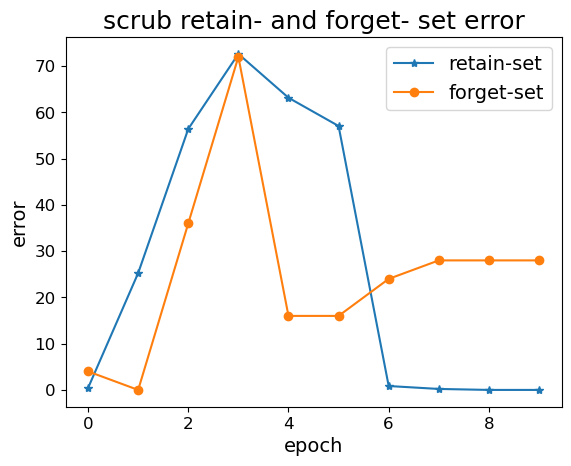

In [90]:
from matplotlib import pyplot as plt
indices = list(range(0,len(acc_rs)))
plt.plot(indices, acc_rs, marker='*', alpha=1, label='retain-set')
plt.plot(indices, acc_fs, marker='o', alpha=1, label='forget-set')
plt.legend(prop={'size': 14})
plt.tick_params(labelsize=12)
plt.title('scrub retain- and forget- set error',size=18)
plt.xlabel('epoch',size=14)
plt.ylabel('error',size=14)
plt.show()

In [144]:
print (acc_rs)
print (acc_fs)

[0.42105865478515625, 18.947372436523438, 65.89473724365234, 73.26315879821777, 60.0, 31.578948974609375, 1.2631607055664062, 0.21053314208984375, 0.21053314208984375, 7.62939453125e-06]
[4.0, 0.0, 44.0, 72.0, 16.0, 24.0, 24.0, 28.0, 28.0, 28.0]


# NTK based Forgetting

#### NTK Update

In [33]:
def delta_w_utils(model_init,dataloader,name='complete'):
    model_init.eval()
    dataloader = torch.utils.data.DataLoader(dataloader.dataset, batch_size=1, shuffle=False)
    G_list = []
    f0_minus_y = []
    for idx, batch in enumerate(dataloader):#(tqdm(dataloader,leave=False)):
        batch = [tensor.to(next(model_init.parameters()).device) for tensor in batch]
        input, target = batch
        if 'mnist' in args.dataset:
            input = input.view(input.shape[0],-1)
        target = target.cpu().detach().numpy()
        output = model_init(input)
        G_sample=[]
        for cls in range(num_classes):
            grads = torch.autograd.grad(output[0,cls],model_init.parameters(),retain_graph=True)
            grads = np.concatenate([g.view(-1).cpu().numpy() for g in grads])
            G_sample.append(grads)
            G_list.append(grads)
        if args.lossfn=='mse':
            p = output.cpu().detach().numpy().transpose()
            #loss_hess = np.eye(len(p))
            target = 2*target-1
            f0_y_update = p-target
        elif args.lossfn=='ce':
            p = torch.nn.functional.softmax(output,dim=1).cpu().detach().numpy().transpose()
            p[target]-=1
            f0_y_update = copy.deepcopy(p)
        f0_minus_y.append(f0_y_update)
    return np.stack(G_list).transpose(),np.vstack(f0_minus_y)

#### Jacobians and Hessians

In [34]:
from sys import getsizeof

In [35]:
ntk_time = 0
model_init = ntk_init(init_checkpoint,args.seed)
t1 = time.time()
G_r,f0_minus_y_r = delta_w_utils(copy.deepcopy(model),retain_loader,'complete')
t2 = time.time()
ntk_time += t2-t1

np.save('NTK_data/G_r.npy',G_r)
np.save('NTK_data/f0_minus_y_r.npy',f0_minus_y_r)
del G_r, f0_minus_y_r

model_init = ntk_init(init_checkpoint,args.seed)
t1 = time.time()
G_f,f0_minus_y_f = delta_w_utils(copy.deepcopy(model),forget_loader,'retain') 
t2 = time.time()
ntk_time += t2-t1

np.save('NTK_data/G_f.npy',G_f)
np.save('NTK_data/f0_minus_y_f.npy',f0_minus_y_f)
del G_f, f0_minus_y_f

FileNotFoundError: [Errno 2] No such file or directory: 'NTK_data/G_r.npy'

In [ ]:
G_r = np.load('NTK_data/G_r.npy')
G_f = np.load('NTK_data/G_f.npy')
G = np.concatenate([G_r,G_f],axis=1)

np.save('NTK_data/G.npy',G)
del G, G_f, G_r

f0_minus_y_r = np.load('NTK_data/f0_minus_y_r.npy')
f0_minus_y_f = np.load('NTK_data/f0_minus_y_f.npy')
f0_minus_y = np.concatenate([f0_minus_y_r,f0_minus_y_f])

np.save('NTK_data/f0_minus_y.npy',f0_minus_y)
del f0_minus_y, f0_minus_y_r, f0_minus_y_f

This only requires access to the gradients and the initialization

### w_lin(D)

In [ ]:
G = np.load('NTK_data/G.npy')
t1 = time.time()
theta = G.transpose().dot(G) + num_total*args.weight_decay*np.eye(G.shape[1])
t2 = time.time()
ntk_time += t2-t1
del G

t1 = time.time()
theta_inv = np.linalg.inv(theta)
t2 = time.time()
ntk_time += t2-t1

np.save('NTK_data/theta.npy',theta)
del theta

G = np.load('NTK_data/G.npy')
f0_minus_y = np.load('NTK_data/f0_minus_y.npy')
t1 = time.time()
w_complete = -G.dot(theta_inv.dot(f0_minus_y))
t2 = time.time()
ntk_time += t2-t1

np.save('NTK_data/theta_inv.npy',theta_inv)
np.save('NTK_data/w_complete.npy',w_complete)

del G, f0_minus_y, theta_inv, w_complete 

### w_lin(D_r)

In [ ]:
G_r = np.load('NTK_data/G_r.npy')
t1 = time.time()
theta_r = G_r.transpose().dot(G_r) + num_to_retain*args.weight_decay*np.eye(G_r.shape[1])
t2 = time.time()
ntk_time += t2-t1
del G_r

t1 = time.time()
theta_r_inv = np.linalg.inv(theta_r)
t2 = time.time()
ntk_time += t2-t1

np.save('NTK_data/theta_r.npy',theta_r)
del theta_r

G_r = np.load('NTK_data/G_r.npy')
f0_minus_y_r = np.load('NTK_data/f0_minus_y_r.npy')
t1 = time.time()
w_retain = -G_r.dot(theta_r_inv.dot(f0_minus_y_r))
t2 = time.time()
ntk_time += t2-t1

np.save('NTK_data/theta_r_inv.npy',theta_r_inv)
np.save('NTK_data/w_retain.npy',w_retain)

del G_r, f0_minus_y_r, theta_r_inv, w_retain 

#### Scrubbing Direction

In [ ]:
#### Scrubbing Direction
w_complete = np.load('NTK_data/w_complete.npy')
w_retain = np.load('NTK_data/w_retain.npy')
delta_w = (w_retain-w_complete).squeeze()

In [ ]:
delta_w_copy = copy.deepcopy(delta_w)

#### Actual Change in Weights

In [ ]:
delta_w_actual = vectorize_params(model0)-vectorize_params(model)

print(f'Actual Norm-: {np.linalg.norm(delta_w_actual)}')
print(f'Predtn Norm-: {np.linalg.norm(delta_w)}')
scale_ratio = np.linalg.norm(delta_w_actual)/np.linalg.norm(delta_w)
print('Actual Scale: {}'.format(scale_ratio))
log_dict['actual_scale_ratio']=scale_ratio

#### Trapezium Trick

In [ ]:
m_pred_error = vectorize_params(model)-vectorize_params(model_init)-w_retain.squeeze()
print(f"Delta w -------: {np.linalg.norm(delta_w)}")

inner = np.inner(delta_w/np.linalg.norm(delta_w),m_pred_error/np.linalg.norm(m_pred_error))
print(f"Inner Product--: {inner}")

if inner<0:
    angle = np.arccos(inner)-np.pi/2
    print(f"Angle----------:  {angle}")

    predicted_norm=np.linalg.norm(delta_w) + 2*np.sin(angle)*np.linalg.norm(m_pred_error)
    print(f"Pred Act Norm--:  {predicted_norm}")
else:
    angle = np.arccos(inner) 
    print(f"Angle----------:  {angle}")

    predicted_norm=np.linalg.norm(delta_w) + 2*np.cos(angle)*np.linalg.norm(m_pred_error)
    print(f"Pred Act Norm--:  {predicted_norm}")

predicted_scale=predicted_norm/np.linalg.norm(delta_w)
predicted_scale
print(f"Predicted Scale:  {predicted_scale}")
log_dict['predicted_scale_ratio']=predicted_scale

#### Normalized Inner Product between Prediction and Actual Scrubbing Update

In [ ]:
def NIP(v1,v2):
    nip = (np.inner(v1/np.linalg.norm(v1),v2/np.linalg.norm(v2)))
    print(nip)
    return nip

In [ ]:
nip=NIP(delta_w_actual,delta_w)
log_dict['nip']=nip

#### Reshape delta_w

In [ ]:
def get_delta_w_dict(delta_w,model):
    # Give normalized delta_w
    delta_w_dict = OrderedDict()
    params_visited = 0
    for k,p in model.named_parameters():
        num_params = np.prod(list(p.shape))
        update_params = delta_w[params_visited:params_visited+num_params]
        delta_w_dict[k] = torch.Tensor(update_params).view_as(p)
        params_visited+=num_params
    return delta_w_dict

### Metrics

In [ ]:
from utils import *
def get_metrics(model,dataloader,criterion,samples_correctness=False,use_bn=False,delta_w=None,scrub_act=False):
    activations=[]
    predictions=[]
    if use_bn:
        model.train()
        dataloader = torch.utils.data.DataLoader(retain_loader.dataset, batch_size=128, shuffle=True)
        for i in range(10):
            for batch_idx, (data, target) in enumerate(dataloader):
                data, target = data.to(args.device), target.to(args.device)            
                output = model(data)
    dataloader = torch.utils.data.DataLoader(dataloader.dataset, batch_size=1, shuffle=False)
    model.eval()
    metrics = AverageMeter()
    mult = 0.5 if args.lossfn=='mse' else 1
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(args.device), target.to(args.device)            
        if args.lossfn=='mse':
            target=(2*target-1)
            target = target.type(torch.cuda.FloatTensor).unsqueeze(1)
        if 'mnist' in args.dataset:
            data=data.view(data.shape[0],-1)
        output = model(data)
        loss = mult*criterion(output, target)
        if samples_correctness:
            activations.append(torch.nn.functional.softmax(output,dim=1).cpu().detach().numpy().squeeze())
            predictions.append(get_error(output,target))
        metrics.update(n=data.size(0), loss=loss.item(), error=get_error(output, target))
    if samples_correctness:
        return metrics.avg,np.stack(activations),np.array(predictions)
    else:
        return metrics.avg

In [ ]:
def activations_predictions(model,dataloader,name):
    criterion = torch.nn.CrossEntropyLoss()
    metrics,activations,predictions=get_metrics(model,dataloader,criterion,True)
    print(f"{name} -> Loss:{np.round(metrics['loss'],3)}, Error:{metrics['error']}")
    log_dict[f"{name}_loss"]=metrics['loss']
    log_dict[f"{name}_error"]=metrics['error']

    return activations,predictions

In [ ]:
def predictions_distance(l1,l2,name):
    dist = np.sum(np.abs(l1-l2))
    print(f"Predictions Distance {name} -> {dist}")
    log_dict[f"{name}_predictions"]=dist

In [ ]:
def activations_distance(a1,a2,name):
    dist = np.linalg.norm(a1-a2,ord=1,axis=1).mean()
    print(f"Activations Distance {name} -> {dist}")
    log_dict[f"{name}_activations"]=dist

# Scrub using NTK

In [ ]:
scale=predicted_scale
direction = get_delta_w_dict(delta_w,model)

model_scrub = copy.deepcopy(model)
for k,p in model_scrub.named_parameters():
    p.data += (direction[k]*scale).to(args.device)

# Fisher Forgetting

### Finetune and Fisher Helper

In [ ]:
from utils import *
def get_metrics(model,dataloader,criterion,samples_correctness=False,use_bn=False,delta_w=None,scrub_act=False):
    activations=[]
    predictions=[]
    if use_bn:
        model.train()
        dataloader = torch.utils.data.DataLoader(retain_loader.dataset, batch_size=128, shuffle=True)
        for i in range(10):
            for batch_idx, (data, target) in enumerate(dataloader):
                data, target = data.to(args.device), target.to(args.device)            
                output = model(data)
    dataloader = torch.utils.data.DataLoader(dataloader.dataset, batch_size=1, shuffle=False)
    model.eval()
    metrics = AverageMeter()
    mult = 0.5 if args.lossfn=='mse' else 1
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(args.device), target.to(args.device)            
        if args.lossfn=='mse':
            target=(2*target-1)
            target = target.type(torch.cuda.FloatTensor).unsqueeze(1)
        if 'mnist' in args.dataset:
            data=data.view(data.shape[0],-1)
        output = model(data)
        if scrub_act:
            G = []
            for cls in range(num_classes):
                grads = torch.autograd.grad(output[0,cls],model.parameters(),retain_graph=True)
                grads = torch.cat([g.view(-1) for g in grads])
                G.append(grads)
            grads = torch.autograd.grad(output_sf[0,cls],model_scrubf.parameters(),retain_graph=False)
            G = torch.stack(G).pow(2)
            delta_f = torch.matmul(G,delta_w)
            output += delta_f.sqrt()*torch.empty_like(delta_f).normal_()

        loss = mult*criterion(output, target)
        if samples_correctness:
            activations.append(torch.nn.functional.softmax(output,dim=1).cpu().detach().numpy().squeeze())
            predictions.append(get_error(output,target))
        metrics.update(n=data.size(0), loss=loss.item(), error=get_error(output, target))
    if samples_correctness:
        return metrics.avg,np.stack(activations),np.array(predictions)
    else:
        return metrics.avg

In [ ]:
def l2_penalty(model,model_init,weight_decay):
    l2_loss = 0
    for (k,p),(k_init,p_init) in zip(model.named_parameters(),model_init.named_parameters()):
        if p.requires_grad:
            l2_loss += (p-p_init).pow(2).sum()
    l2_loss *= (weight_decay/2.)
    return l2_loss

def run_train_epoch(model: nn.Module, model_init, data_loader: torch.utils.data.DataLoader, 
                    loss_fn: nn.Module,
                    optimizer: torch.optim.SGD, split: str, epoch: int, ignore_index=None,
                    negative_gradient=False, negative_multiplier=-1, random_labels=False,
                    quiet=False,delta_w=None,scrub_act=False):
    model.eval()
    metrics = AverageMeter()    
    num_labels = data_loader.dataset.targets.max().item() + 1
    
    with torch.set_grad_enabled(split != 'test'):
        for idx, batch in enumerate(tqdm(data_loader, leave=False)):
            batch = [tensor.to(next(model.parameters()).device) for tensor in batch]
            input, target = batch
            output = model(input)
            if split=='test' and scrub_act:
                G = []
                for cls in range(num_classes):
                    grads = torch.autograd.grad(output[0,cls],model.parameters(),retain_graph=True)
                    grads = torch.cat([g.view(-1) for g in grads])
                    G.append(grads)
                grads = torch.autograd.grad(output_sf[0,cls],model_scrubf.parameters(),retain_graph=False)
                G = torch.stack(G).pow(2)
                delta_f = torch.matmul(G,delta_w)
                output += delta_f.sqrt()*torch.empty_like(delta_f).normal_()
            loss = loss_fn(output, target) + l2_penalty(model,model_init,args.weight_decay)
            metrics.update(n=input.size(0), loss=loss_fn(output,target).item(), error=get_error(output, target))
            
            if split != 'test':
                model.zero_grad()
                loss.backward()
                optimizer.step()
    if not quiet:
        log_metrics(split, metrics, epoch)
    return metrics.avg

def run_neggrad_epoch(model: nn.Module, model_init, data_loader: torch.utils.data.DataLoader, 
                    forget_loader: torch.utils.data.DataLoader,
                    alpha: float,
                    loss_fn: nn.Module,
                    optimizer: torch.optim.SGD, split: str, epoch: int, ignore_index=None,
                    quiet=False):
    model.eval()
    metrics = AverageMeter()    
    num_labels = data_loader.dataset.targets.max().item() + 1
    
    with torch.set_grad_enabled(split != 'test'):
        for idx, (batch_retain,batch_forget) in enumerate(tqdm(zip(data_loader,cycle(forget_loader)), leave=False)):
            batch_retain = [tensor.to(next(model.parameters()).device) for tensor in batch_retain]
            batch_forget = [tensor.to(next(model.parameters()).device) for tensor in batch_forget]
            input_r, target_r = batch_retain
            input_f, target_f = batch_forget
            output_r = model(input_r)
            output_f = model(input_f)
            loss = alpha*(loss_fn(output_r, target_r) + l2_penalty(model,model_init,args.weight_decay)) - (1-alpha)*loss_fn(output_f, target_f)
            metrics.update(n=input_r.size(0), loss=loss_fn(output_r,target_r).item(), error=get_error(output_r, target_r))
            if split != 'test':
                model.zero_grad()
                loss.backward()
                optimizer.step()
    if not quiet:
        log_metrics(split, metrics, epoch)
    return metrics.avg

In [ ]:
def finetune(model: nn.Module, data_loader: torch.utils.data.DataLoader, lr=0.01, epochs=10, quiet=False):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.0)
    model_init=copy.deepcopy(model)
    for epoch in range(epochs):
        run_train_epoch(model, model_init, data_loader, loss_fn, optimizer, split='train', epoch=epoch, ignore_index=None, quiet=quiet)
        #train_vanilla(epoch, data_loader, model, loss_fn, optimizer, args)

def negative_grad(model: nn.Module, data_loader: torch.utils.data.DataLoader, forget_loader: torch.utils.data.DataLoader, alpha: float, lr=0.01, epochs=10, quiet=False):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.0)
    model_init=copy.deepcopy(model)
    for epoch in range(epochs):
        run_neggrad_epoch(model, model_init, data_loader, forget_loader, alpha, loss_fn, optimizer, split='train', epoch=epoch, ignore_index=None, quiet=quiet)
        #train_negrad(epoch, data_loader, forget_loader, model, loss_fn, optimizer,  alpha)

def fk_fientune(model: nn.Module, data_loader: torch.utils.data.DataLoader, args, lr=0.01, epochs=10, quiet=False):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.0)
    model_init=copy.deepcopy(model)
    for epoch in range(epochs):
        sgda_adjust_learning_rate(epoch, args, optimizer)
        run_train_epoch(model, model_init, data_loader, loss_fn, optimizer, split='train', epoch=epoch, ignore_index=None, quiet=quiet)
        #train_negrad(epoch, data_loader, forget_loader, model, loss_fn, optimizer,  alpha)
def test(model, data_loader):
    loss_fn = nn.CrossEntropyLoss()
    model_init=copy.deepcopy(model)
    return run_train_epoch(model, model_init, data_loader, loss_fn, optimizer=None, split='test', epoch=epoch, ignore_index=None, quiet=True)

In [ ]:
def readout_retrain(model, data_loader, test_loader, lr=0.1, epochs=500, threshold=0.01, quiet=True):
    torch.manual_seed(seed)
    model = copy.deepcopy(model)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.0)
    sampler = torch.utils.data.RandomSampler(data_loader.dataset, replacement=True, num_samples=500)
    data_loader_small = torch.utils.data.DataLoader(data_loader.dataset, batch_size=data_loader.batch_size, sampler=sampler, num_workers=data_loader.num_workers)
    metrics = []
    model_init=copy.deepcopy(model)
    for epoch in range(epochs):
        metrics.append(run_train_epoch(model, model_init, test_loader, loss_fn, optimizer, split='test', epoch=epoch, ignore_index=None, quiet=quiet))
        if metrics[-1]['loss'] <= threshold:
            break
        run_train_epoch(model, model_init, data_loader_small, loss_fn, optimizer, split='train', epoch=epoch, ignore_index=None, quiet=quiet)
    return epoch, metrics

def extract_retrain_time(metrics, threshold=0.1):
    losses = np.array([m['loss'] for m in metrics])
    return np.argmax(losses < threshold)

def all_readouts(model,thresh=0.1,name='method'):
    train_loader = torch.utils.data.DataLoader(train_loader_full.dataset, batch_size=args.batch_size, shuffle=True)
    retrain_time, _ = readout_retrain(model, train_loader, forget_loader, epochs=100, lr=0.1, threshold=thresh)
    test_error = test(model, test_loader_full)['error']
    forget_error = test(model, forget_loader)['error']
    retain_error = test(model, retain_loader)['error']
    print(f"{name} ->"
          f"\tFull test error: {test_error:.2%}"
          f"\tForget error: {forget_error:.2%}\tRetain error: {retain_error:.2%}"
          f"\tFine-tune time: {retrain_time+1} steps")
    log_dict[f"{name}_retrain_time"]=retrain_time+1
    return(dict(test_error=test_error, forget_error=forget_error, retain_error=retain_error, retrain_time=retrain_time))

# Fisher

In [ ]:
model_scrubf = copy.deepcopy(model_scrub)
modelf = copy.deepcopy(model)
modelf0 = copy.deepcopy(model0)

for p in itertools.chain(modelf.parameters(), modelf0.parameters(), model_scrubf.parameters()):
    p.data0 = copy.deepcopy(p.data.clone())

In [ ]:
def hessian(dataset, model):
    model.eval()
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
    loss_fn = nn.CrossEntropyLoss()

    for p in model.parameters():
        p.grad_acc = 0
        p.grad2_acc = 0
    
    for data, orig_target in tqdm(train_loader):
        data, orig_target = data.to(args.device), orig_target.to(args.device)
        output = model(data)
        prob = F.softmax(output, dim=-1).data

        for y in range(output.shape[1]):
            target = torch.empty_like(orig_target).fill_(y)
            loss = loss_fn(output, target)
            model.zero_grad()
            loss.backward(retain_graph=True)
            for p in model.parameters():
                if p.requires_grad:
                    p.grad_acc += (orig_target == target).float() * p.grad.data
                    p.grad2_acc += prob[:, y] * p.grad.data.pow(2)
    for p in model.parameters():
        p.grad_acc /= len(train_loader)
        p.grad2_acc /= len(train_loader)

In [ ]:
hessian(retain_loader.dataset, model_scrubf)
hessian(retain_loader.dataset, modelf)
hessian(retain_loader.dataset, modelf0)

In [ ]:
def get_mean_var(p, is_base_dist=False, alpha=3e-6):
    var = copy.deepcopy(1./(p.grad2_acc+1e-8))
    var = var.clamp(max=1e3)
    if p.size(0) == num_classes:
        var = var.clamp(max=1e2)
    var = alpha * var
    
    if p.ndim > 1:
        var = var.mean(dim=1, keepdim=True).expand_as(p).clone()
    if not is_base_dist:
        mu = copy.deepcopy(p.data0.clone())
    else:
        mu = copy.deepcopy(p.data0.clone())
    if p.size(0) == num_classes and num_to_forget is None:
        mu[class_to_forget] = 0
        var[class_to_forget] = 0.0001
    if p.size(0) == num_classes:
        # Last layer
        var *= 10
    elif p.ndim == 1:
        # BatchNorm
        var *= 10
#         var*=1
    return mu, var

def kl_divergence_fisher(mu0, var0, mu1, var1):
    return ((mu1 - mu0).pow(2)/var0 + var1/var0 - torch.log(var1/var0) - 1).sum()

## Fisher Noise in Weights

In [ ]:
# Computes the amount of information not forgotten at all layers using the given alpha
alpha = 1e-7
total_kl = 0
torch.manual_seed(seed)
for (k, p), (k0, p0) in zip(modelf.named_parameters(), modelf0.named_parameters()):
    mu0, var0 = get_mean_var(p, False, alpha=alpha)
    mu1, var1 = get_mean_var(p0, True, alpha=alpha)
    kl = kl_divergence_fisher(mu0, var0, mu1, var1).item()
    total_kl += kl
    print(k, f'{kl:.1f}')
print("Total:", total_kl)
log_dict['fisher_info']=total_kl

In [ ]:
fisher_dir = []
alpha = 1e-6
torch.manual_seed(seed)
for i, p in enumerate(modelf.parameters()):
    mu, var = get_mean_var(p, False, alpha=alpha)
    p.data = mu + var.sqrt() * torch.empty_like(p.data0).normal_()
    fisher_dir.append(var.sqrt().view(-1).cpu().detach().numpy())

for i, p in enumerate(modelf0.parameters()):
    mu, var = get_mean_var(p, False, alpha=alpha)
    p.data = mu + var.sqrt() * torch.empty_like(p.data0).normal_()

In [ ]:
print(test(modelf, retain_loader))
print(test(modelf, forget_loader))
print(test(modelf, valid_loader_full))
print(test(modelf, test_loader_full))

### Finetune

In [ ]:
model_ft = copy.deepcopy(model)
retain_loader = replace_loader_dataset(train_loader_full,retain_dataset, seed=seed, batch_size=args.batch_size, shuffle=True)    
finetune(model_ft, retain_loader, epochs=10, quiet=True, lr=0.01)

### Negative Gradient

In [ ]:
args.ng_alpha = 0.95
args.ng_epochs = 10
args.ng_lr = 0.01
model_ng = copy.deepcopy(model)    
negative_grad(model_ng, retain_loader, forget_loader, alpha=args.ng_alpha, epochs=args.ng_epochs, quiet=True, lr=args.ng_lr)

### Catastrophic Forgetting k layers

In [ ]:
args.lr_decay_epochs = [10,15,20]
args.cfk_lr = 0.01
args.cfk_epochs = 10

model_cfk = copy.deepcopy(model)

for param in model_cfk.parameters():
    param.requires_grad_(False)

if args.model == 'allcnn':
    layers = [9]
    for k in layers:
        for param in model_cfk.features[k].parameters():
            param.requires_grad_(True)
    
elif args.model == "resnet":
    for param in model_cfk.layer4.parameters():
        param.requires_grad_(True)

else:
    raise NotImplementedError


fk_fientune(model_cfk, retain_loader, args=args, epochs=args.cfk_epochs, quiet=True, lr=args.cfk_lr)

### Exact Unlearning k layers

In [ ]:
""" The last block and classifier of resnet-18
(layer4): Sequential(
    (0): _ResBlock(
      (bn1): BatchNorm2d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(102, 204, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn2): BatchNorm2d(204, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(204, 204, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential(
        (0): Conv2d(102, 204, kernel_size=(1, 1), stride=(2, 2), bias=False)
      )
    )
    (1): _ResBlock(
      (bn1): BatchNorm2d(204, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(204, 204, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(204, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(204, 204, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
(linear): Linear(in_features=204, out_features=5, bias=True)
"""

""" The last block and classifier of allcnn
AllCNN(
  (features): Sequential(
    ...
    (9): Conv(
      (0): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (10): AvgPool2d(kernel_size=8, stride=8, padding=0)
    (11): Flatten()
  )
  (classifier): Sequential(
    (0): Linear(in_features=192, out_features=5, bias=True)
  )
)
"""

In [ ]:
args.lr_decay_epochs = [10,15,20]
args.euk_lr = 0.01
args.euk_epochs = training_epochs
model_euk = copy.deepcopy(model)

for param in model_euk.parameters():
    param.requires_grad_(False)

if args.model == 'allcnn':
    with torch.no_grad():
        for k in layers:
            for i in range(0,3):
                try:
                    model_euk.features[k][i].weight.copy_(model_initial.features[k][i].weight)
                except:
                    print ("block {}, layer {} does not have weights".format(k,i))
                try:
                    model_euk.features[k][i].bias.copy_(model_initial.features[k][i].bias)
                except:
                    print ("block {}, layer {} does not have bias".format(k,i))
        model_euk.classifier[0].weight.copy_(model_initial.classifier[0].weight)
        model_euk.classifier[0].bias.copy_(model_initial.classifier[0].bias)
    
    for k in layers:
        for param in model_euk.features[k].parameters():
            param.requires_grad_(True)
    
elif args.model == "resnet":
    with torch.no_grad():
        for i in range(0,2):
            try:
                model_euk.layer4[i].bn1.weight.copy_(model_initial.layer4[i].bn1.weight)
            except:
                print ("block 4, layer {} does not have weight".format(i))
            try:
                model_euk.layer4[i].bn1.bias.copy_(model_initial.layer4[i].bn1.bias)
            except:
                print ("block 4, layer {} does not have bias".format(i))
            try:
                model_euk.layer4[i].conv1.weight.copy_(model_initial.layer4[i].conv1.weight)
            except:
                print ("block 4, layer {} does not have weight".format(i))
            try:
                model_euk.layer4[i].conv1.bias.copy_(model_initial.layer4[i].conv1.bias)
            except:
                print ("block 4, layer {} does not have bias".format(i))

            try:
                model_euk.layer4[i].bn2.weight.copy_(model_initial.layer4[i].bn2.weight)
            except:
                print ("block 4, layer {} does not have weight".format(i))
            try:
                model_euk.layer4[i].bn2.bias.copy_(model_initial.layer4[i].bn2.bias)
            except:
                print ("block 4, layer {} does not have bias".format(i))
            try:
                model_euk.layer4[i].conv2.weight.copy_(model_initial.layer4[i].conv2.weight)
            except:
                print ("block 4, layer {} does not have weight".format(i))
            try:
                model_euk.layer4[i].conv2.bias.copy_(model_initial.layer4[i].conv2.bias)
            except:
                print ("block 4, layer {} does not have bias".format(i))

        model_euk.layer4[0].shortcut[0].weight.copy_(model_initial.layer4[0].shortcut[0].weight)
        
    for param in model_euk.layer4.parameters():
        param.requires_grad_(True)

else:
    raise NotImplementedError

fk_fientune(model_euk, retain_loader, epochs=args.euk_epochs, quiet=True, lr=args.euk_lr, args=args)

### Readouts

In [ ]:
try: readouts
except: readouts = {}

_,_=activations_predictions(copy.deepcopy(model),forget_loader,'Original_Model_D_f')
thresh=log_dict['Original_Model_D_f_loss']+1e-5
print(thresh)
readouts["a"] = all_readouts(copy.deepcopy(model),thresh,'Original')
readouts["b"] = all_readouts(copy.deepcopy(model0),thresh,'Retrain')
readouts["c"] = all_readouts(copy.deepcopy(model_ft),thresh,'Finetune')
readouts["d"] = all_readouts(copy.deepcopy(model_ng),thresh,'NegGrad')
readouts["e"] = all_readouts(copy.deepcopy(model_cfk),thresh,'CF-k')
readouts["f"] = all_readouts(copy.deepcopy(model_euk),thresh,'EU-k')
readouts["g"] = all_readouts(copy.deepcopy(modelf),thresh,'Fisher')
readouts["h"] = all_readouts(copy.deepcopy(model_scrub),thresh,'NTK')
readouts["i"] = all_readouts(copy.deepcopy(model_s),thresh,'SCRUB')